In [79]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import graphviz
from graphviz import Graph

import env
import wrangle_zillow
import os

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
# change display settings to show all columns
pd.set_option("display.max_columns", None)

In [3]:
# use a function to pull in zillow data
df = wrangle_zillow.wrangle_zillow()
df.shape

(50782, 24)

In [4]:
# use a function to split data for exploring and modeling
train, validate, test = wrangle_zillow.split_data(df)
train.head(3)

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,bath_bed_ratio
12794,2.00,4,1352,los_angeles,34273883,-118492869,6925,12447.00,3101,96370,0.00,1955.00,148000,505000,2016,357000,6228,0.03,2017-02-27,1,0,0,62,0.50
76021,3.00,4,1980,los_angeles,34362339,-117653901,8763,21395.00,3101,97324,0.00,1981.00,243342,303236,2016,59894,3275,0.15,2017-09-13,1,0,0,36,0.75
16536,3.00,3,1484,los_angeles,34288283,-118376120,12470,12447.00,3101,96368,0.00,1990.00,177997,311590,2016,133593,3881,-0.03,2017-03-13,1,0,0,27,1.00


In [5]:
train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,bath_bed_ratio
12794,2.00,4,1352,los_angeles,34273883,-118492869,6925,12447.00,3101,96370,0.00,1955.00,148000,505000,2016,357000,6228,0.03,2017-02-27,1,0,0,62,0.50
76021,3.00,4,1980,los_angeles,34362339,-117653901,8763,21395.00,3101,97324,0.00,1981.00,243342,303236,2016,59894,3275,0.15,2017-09-13,1,0,0,36,0.75
16536,3.00,3,1484,los_angeles,34288283,-118376120,12470,12447.00,3101,96368,0.00,1990.00,177997,311590,2016,133593,3881,-0.03,2017-03-13,1,0,0,27,1.00
114,2.00,3,1731,orange,33883151,-117869121,8000,26531.00,1286,97068,7.00,1963.00,52482,73745,2016,21263,1353,0.02,2017-01-03,0,1,0,54,0.67
48044,1.00,3,1011,los_angeles,33921848,-118247414,5970,118994.00,3101,96040,0.00,1946.00,43615,136298,2016,92683,2101,0.02,2017-06-20,1,0,0,71,0.33


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28437 entries, 12794 to 43905
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathrooms          28437 non-null  float64
 1   bedrooms           28437 non-null  int64  
 2   area               28437 non-null  int64  
 3   counties           28437 non-null  object 
 4   latitude           28437 non-null  int64  
 5   longitude          28437 non-null  int64  
 6   lot_area           28437 non-null  int64  
 7   regionidcity       28437 non-null  float64
 8   regionidcounty     28437 non-null  object 
 9   regionidzip        28437 non-null  object 
 10  roomcnt            28437 non-null  float64
 11  yearbuilt          28437 non-null  float64
 12  structuretaxvalue  28437 non-null  int64  
 13  taxvalue           28437 non-null  int64  
 14  assessmentyear     28437 non-null  object 
 15  landtaxvalue       28437 non-null  int64  
 16  taxamount         

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,28437.00,2.25,0.93,1.00,2.00,2.00,3.00,10.00
bedrooms,28437.00,3.28,0.92,1.00,3.00,3.00,4.00,11.00
area,28437.00,1857.23,852.84,152.00,1260.00,1639.00,2243.00,10686.00
latitude,28437.00,34024832.17,275212.67,33340620.00,33826576.00,34021597.00,34191116.00,34818767.00
longitude,28437.00,-118191297.62,357901.21,-119447944.00,-118394397.00,-118147156.00,-117928314.00,-117554636.00
lot_area,28437.00,11417.18,105468.85,480.00,5558.00,6763.00,8568.00,6971010.00
regionidcity,28437.00,33382.90,49436.24,3491.00,12447.00,24812.00,40227.00,396556.00
roomcnt,28437.00,1.92,3.14,0.00,0.00,0.00,5.00,14.00
yearbuilt,28437.00,1963.24,22.91,1878.00,1950.00,1961.00,1979.00,2015.00
structuretaxvalue,28437.00,171990.86,149790.60,148.00,75771.00,128632.00,214968.00,1646927.00


<AxesSubplot:>

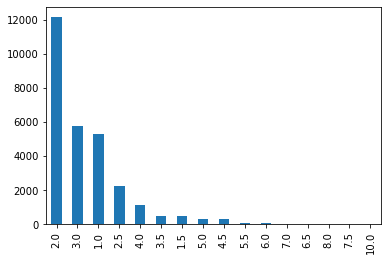

In [8]:
# check bathroom value counts
train.bathrooms.value_counts().plot.bar()

<AxesSubplot:>

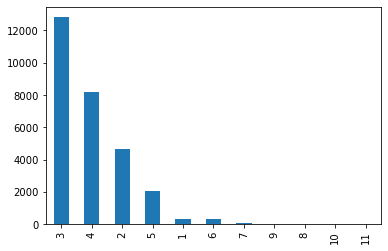

In [9]:
# check bedroom value counts
train.bedrooms.value_counts().plot.bar()

<AxesSubplot:>

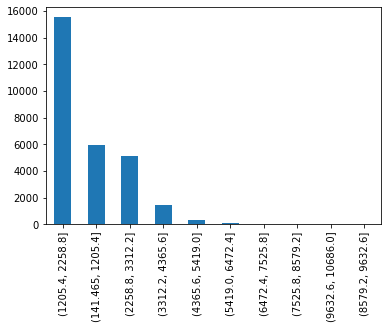

In [10]:
# check binned area value counts
train.area.value_counts(bins=10).plot.bar()

<AxesSubplot:>

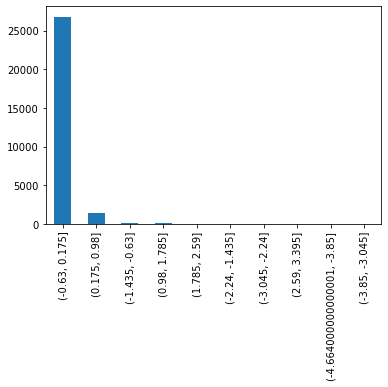

In [11]:
# check binned logerror value counts
train.logerror.value_counts(bins=10).plot.bar()

<AxesSubplot:>

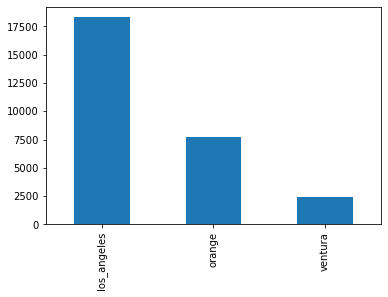

In [12]:
# check binned logerror value counts
train.counties.value_counts().plot.bar()

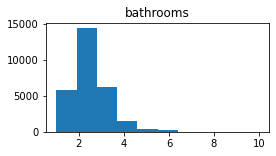

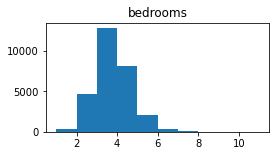

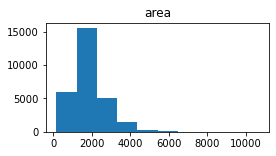

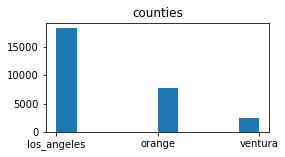

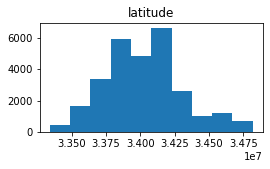

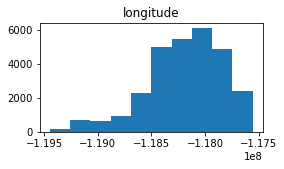

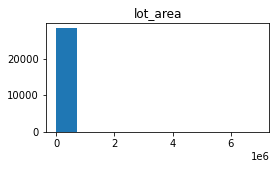

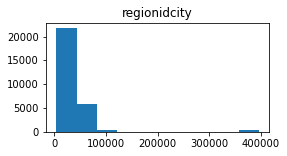

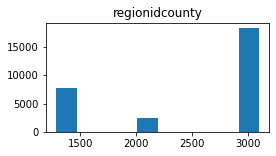

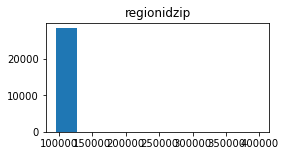

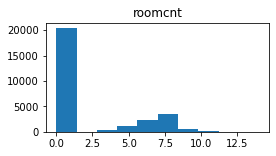

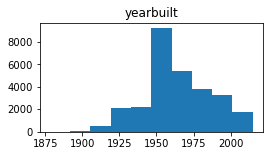

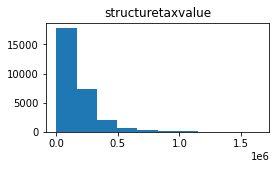

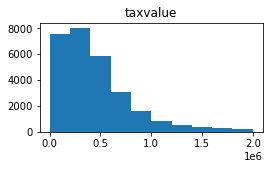

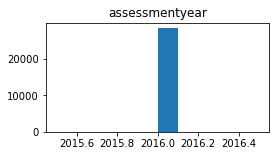

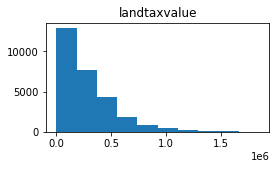

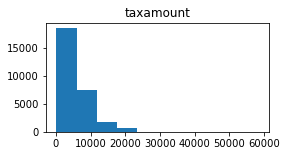

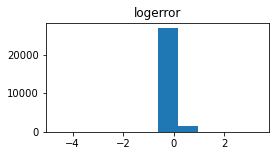

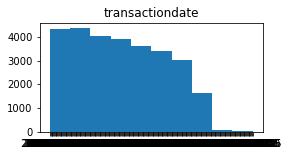

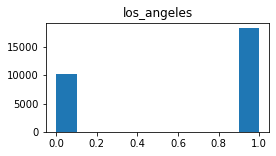

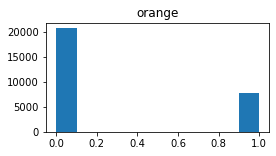

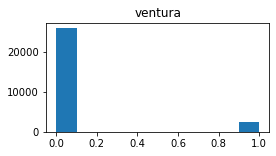

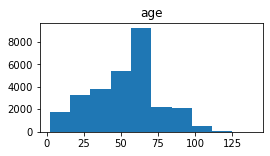

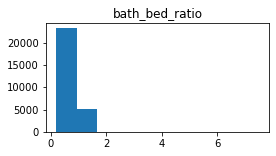

In [13]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

<AxesSubplot:>

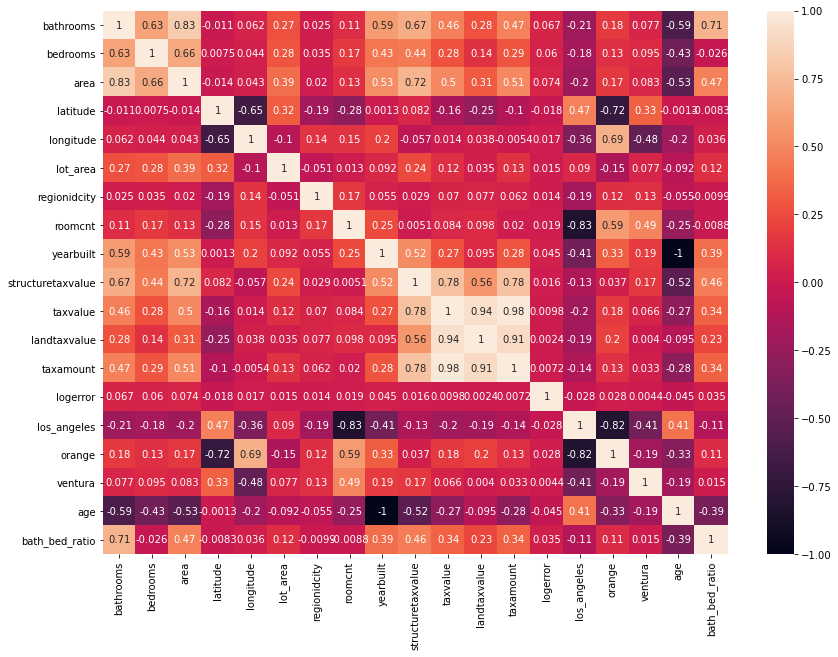

In [14]:
# use a heatmap to see if there are any obvious correlations
plt.figure(figsize=(14,10))
sns.heatmap(train.corr(method='spearman'), annot=True)

### Many of the features seem to be skewed to the right

### Bathrooms, bedrooms, area, and age have the highest correlation with logerror

### There are almost twice as many properties in LA County than Orange & Ventura county

## Is there a difference in mean logerror for each of the counties?

In [15]:
train.head(3)

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,bath_bed_ratio
12794,2.00,4,1352,los_angeles,34273883,-118492869,6925,12447.00,3101,96370,0.00,1955.00,148000,505000,2016,357000,6228,0.03,2017-02-27,1,0,0,62,0.50
76021,3.00,4,1980,los_angeles,34362339,-117653901,8763,21395.00,3101,97324,0.00,1981.00,243342,303236,2016,59894,3275,0.15,2017-09-13,1,0,0,36,0.75
16536,3.00,3,1484,los_angeles,34288283,-118376120,12470,12447.00,3101,96368,0.00,1990.00,177997,311590,2016,133593,3881,-0.03,2017-03-13,1,0,0,27,1.00


In [16]:
# check mean logerror for each county
train.groupby('counties').logerror.mean()

counties
los_angeles   0.02
orange        0.02
ventura       0.02
Name: logerror, dtype: float64

In [17]:
# code is not producing the same result as groupby likely due to rounding
train[train.counties == 'los_angeles'].logerror.mean()

0.015888107084402518

In [18]:
# code is not producing the same result as groupby likely due to rounding
train[train.counties == 'orange'].logerror.mean()

0.02310369821347422

In [19]:
# code is not producing the same result as groupby likely due to rounding
train[train.counties == 'ventura'].logerror.mean()

0.016804598418300867

**My project partner explored this in greater depth with statistical testing and determined there was a significant difference in logerror by county**

In [20]:
# Use .describe with object columns.
obj_cols = train.columns[[train[col].dtype == 'O' for col in train.columns]]
for col in obj_cols:
    print(train[col].value_counts())
    print(train[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

los_angeles    18299
orange          7707
ventura         2431
Name: counties, dtype: int64
los_angeles   0.64
orange        0.27
ventura       0.09
Name: counties, dtype: float64
----------------------
3101    18299
1286     7707
2061     2431
Name: regionidcounty, dtype: int64
3101   0.64
1286   0.27
2061   0.09
Name: regionidcounty, dtype: float64
----------------------
97319    435
97318    370
97328    298
97329    295
97118    284
        ... 
96434      2
95996      1
96467      1
96038      1
96323      1
Name: regionidzip, Length: 376, dtype: int64
97319   0.02
97318   0.01
97328   0.01
97329   0.01
97118   0.01
        ... 
96434   0.00
95996   0.00
96467   0.00
96038   0.00
96323   0.00
Name: regionidzip, Length: 376, dtype: float64
----------------------
2016    28437
Name: assessmentyear, dtype: int64
2016   1.00
Name: assessmentyear, dtype: float64
----------------------
2017-06-30    440
2017-04-28    335
2017-07-28    301
2017-08-31    301
2017-05-31    296
            

## What does absolute logerror look like from county to county?

In [21]:
# check the range for logerror
train.logerror.describe()

count   28437.00
mean        0.02
std         0.18
min        -4.66
25%        -0.02
50%         0.01
75%         0.04
max         3.39
Name: logerror, dtype: float64

In [22]:
# add a column that bins each value of logerror into max, min, or med absolute error
train['log_e'] = pd.cut(train.logerror, bins=[-5,-1,-.03,.03,1,5], ordered=False, labels=['max','med','min','med','max'])
train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,bath_bed_ratio,log_e
12794,2.00,4,1352,los_angeles,34273883,-118492869,6925,12447.00,3101,96370,0.00,1955.00,148000,505000,2016,357000,6228,0.03,2017-02-27,1,0,0,62,0.50,min
76021,3.00,4,1980,los_angeles,34362339,-117653901,8763,21395.00,3101,97324,0.00,1981.00,243342,303236,2016,59894,3275,0.15,2017-09-13,1,0,0,36,0.75,med
16536,3.00,3,1484,los_angeles,34288283,-118376120,12470,12447.00,3101,96368,0.00,1990.00,177997,311590,2016,133593,3881,-0.03,2017-03-13,1,0,0,27,1.00,med
114,2.00,3,1731,orange,33883151,-117869121,8000,26531.00,1286,97068,7.00,1963.00,52482,73745,2016,21263,1353,0.02,2017-01-03,0,1,0,54,0.67,min
48044,1.00,3,1011,los_angeles,33921848,-118247414,5970,118994.00,3101,96040,0.00,1946.00,43615,136298,2016,92683,2101,0.02,2017-06-20,1,0,0,71,0.33,min


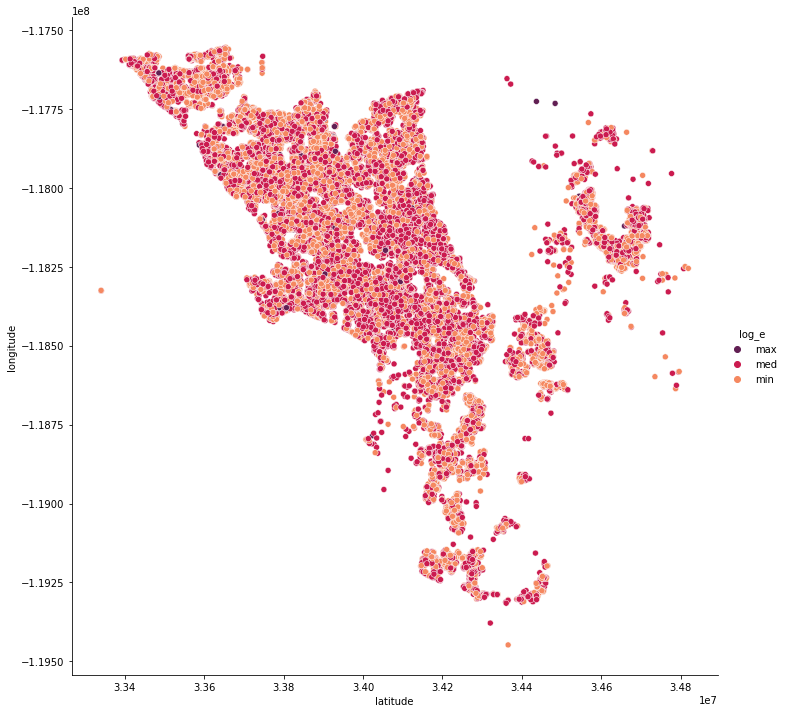

In [23]:
# plot the data to see which areas have the most logerror
sns.relplot(data=train, x='latitude', y='longitude', hue='log_e', hue_order=['max', 'med','min'], height=10, palette='rocket')

### As seen towards the center of the graph, Los Angeles County does have a higher proportion of med - max logerror which could mean the model has a harder time predicting home values from this location or could just be due to the larger number of properties sold in this area

In [24]:
# use crosstab to visualize the number of each category per county
pd.crosstab(train.counties, train.log_e)

log_e,max,med,min
counties,,,
los_angeles,70,10204,8025
orange,60,3522,4125
ventura,9,1118,1304


<AxesSubplot:xlabel='counties', ylabel='proportion'>

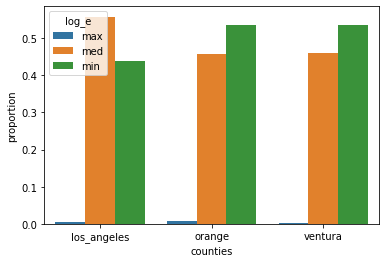

In [25]:
# plot the data to see if any county has a higher percentage of max logerrors
x, y, hue = 'counties', 'proportion', 'log_e'
hue_order = ['max', 'med', 'min']

(train[hue]
 .groupby(train[x])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

### We can barely see on the graph but it looks like the model produces a slightly higher percentage of max errors for Orange County but a higher percentage of medium error for Los Angeles County

In [26]:
# drop log_e to prep for clustering
train = train.drop(columns='log_e')
train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,bath_bed_ratio
12794,2.00,4,1352,los_angeles,34273883,-118492869,6925,12447.00,3101,96370,0.00,1955.00,148000,505000,2016,357000,6228,0.03,2017-02-27,1,0,0,62,0.50
76021,3.00,4,1980,los_angeles,34362339,-117653901,8763,21395.00,3101,97324,0.00,1981.00,243342,303236,2016,59894,3275,0.15,2017-09-13,1,0,0,36,0.75
16536,3.00,3,1484,los_angeles,34288283,-118376120,12470,12447.00,3101,96368,0.00,1990.00,177997,311590,2016,133593,3881,-0.03,2017-03-13,1,0,0,27,1.00
114,2.00,3,1731,orange,33883151,-117869121,8000,26531.00,1286,97068,7.00,1963.00,52482,73745,2016,21263,1353,0.02,2017-01-03,0,1,0,54,0.67
48044,1.00,3,1011,los_angeles,33921848,-118247414,5970,118994.00,3101,96040,0.00,1946.00,43615,136298,2016,92683,2101,0.02,2017-06-20,1,0,0,71,0.33


In [27]:
# use a function to create X and y datasets for train, validate, and test
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow.prep_zillow_for_model(train, validate, test)
X_train.head()

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,los_angeles,orange,ventura,age,bath_bed_ratio
0,0.11,0.30,0.11,0.63,0.50,0.00,0.02,0.00,0.56,0.09,0.25,0.19,0.11,1.00,0.00,0.00,0.44,0.04
1,0.22,0.30,0.17,0.69,0.95,0.00,0.05,0.00,0.75,0.15,0.15,0.03,0.06,1.00,0.00,0.00,0.25,0.08
2,0.22,0.20,0.13,0.64,0.57,0.00,0.02,0.00,0.82,0.11,0.15,0.07,0.07,1.00,0.00,0.00,0.18,0.11
3,0.11,0.20,0.15,0.37,0.83,0.00,0.06,0.50,0.62,0.03,0.04,0.01,0.02,0.00,1.00,0.00,0.38,0.06
4,0.00,0.20,0.08,0.39,0.63,0.00,0.29,0.00,0.50,0.03,0.07,0.05,0.04,1.00,0.00,0.00,0.50,0.02


In [29]:
# select the features to use
X = X_train[['age', 'taxvalue']]

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'taxvalue'}>]], dtype=object)

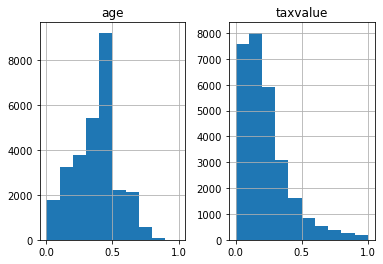

In [30]:
# visualize distribution
X.hist()

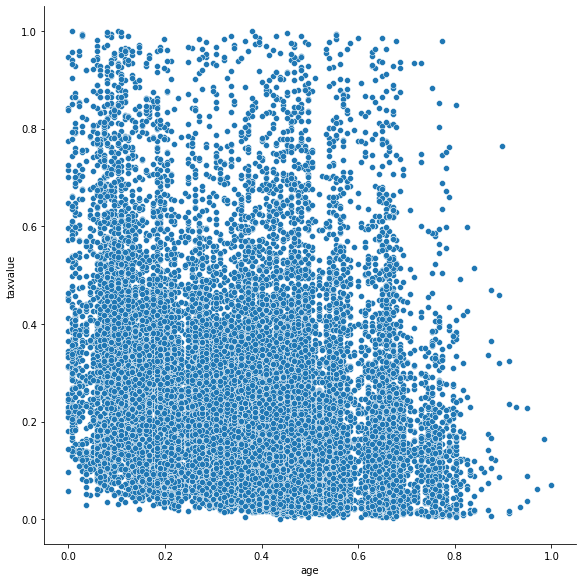

In [49]:
# visualize data to see if there are any obvious clusters
sns.relplot(x = 'age', y ='taxvalue', data = X_train, height=8)

**There are no obvious clusters so I will use the elbow method to see if I can find a good value for k**

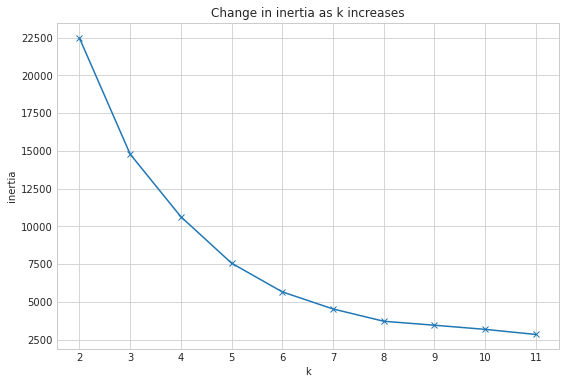

In [39]:
# use elbow method to see what might be a good value for k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Based on this visualization, I will start by using a k of 5 since the slope starts tapering off after that

In [98]:
# use KMeans to create cluster

# define the thing
kmeans = KMeans(n_clusters=5, random_state = 369)

# fit the thing
kmeans.fit(X)

# Use the thing to predict
kmeans.predict(X)

array([1, 0, 0, ..., 4, 0, 1], dtype=int32)

In [99]:
# create a new column with the predicted cluster in the original X_train
X_train['agetax_cluster'] = kmeans.predict(X)
X_train.head(2)

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,los_angeles,orange,ventura,age,bath_bed_ratio,cluster,agetax_cluster
0,0.11,0.30,0.11,0.63,0.50,0.00,0.02,0.00,0.56,0.09,0.25,0.19,0.11,1.00,0.00,0.00,0.44,0.04,0,1
1,0.22,0.30,0.17,0.69,0.95,0.00,0.05,0.00,0.75,0.15,0.15,0.03,0.06,1.00,0.00,0.00,0.25,0.08,1,0


In [100]:
# create dataframe of cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,age,taxvalue
0,0.18,0.23
1,0.44,0.34
2,0.25,0.68
3,0.65,0.13
4,0.42,0.11


<AxesSubplot:xlabel='age', ylabel='taxvalue'>

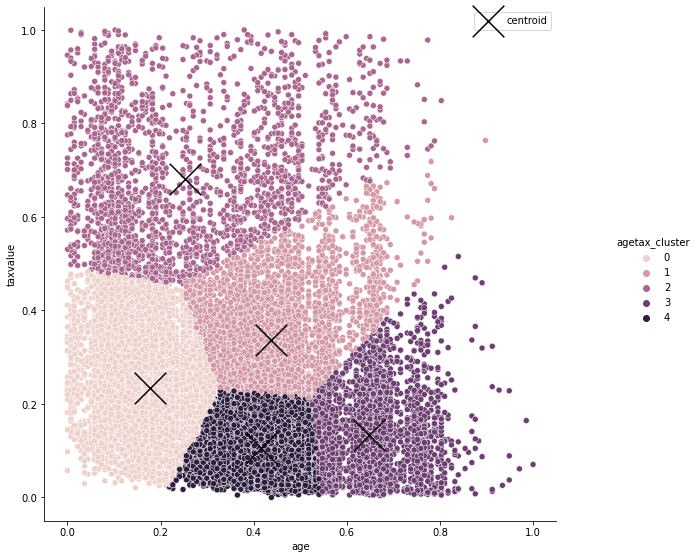

In [101]:
# visualize clustering results
sns.relplot(x = 'age', y ='taxvalue', data = X_train, hue = 'agetax_cluster')

centroids.plot.scatter(x='age', y='taxvalue', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid', figsize=(10, 8))

<AxesSubplot:xlabel='cluster', ylabel='logerror'>

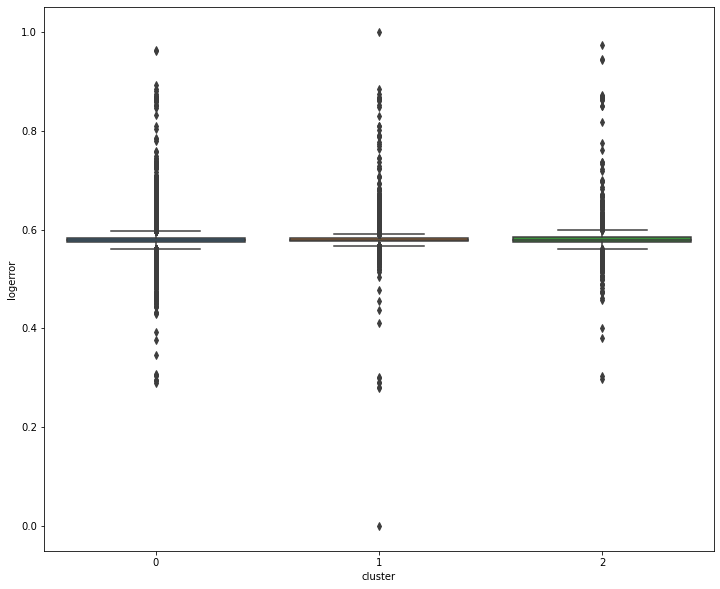

In [102]:
# visualize distribution of logerror by cluster
plt.figure(figsize=(12,10))
sns.boxplot(
    x='cluster',
    y=y_train,
    data=X_train)

<AxesSubplot:xlabel='age', ylabel='taxvalue'>

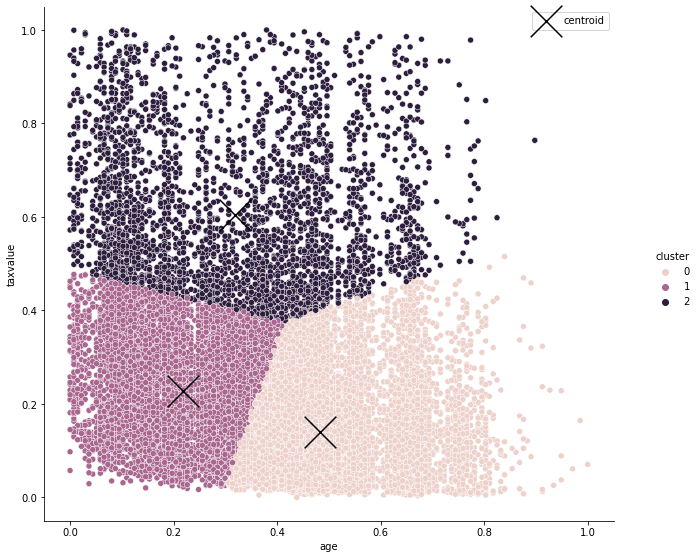

In [93]:
# use KMeans to create 3 clusters

# define the thing
kmeans = KMeans(n_clusters=3, random_state = 369)

# fit the thing
kmeans.fit(X)

# Use the thing to predict
kmeans.predict(X)

# create a new column with the predicted cluster in the original X_train
X_train['cluster'] = kmeans.predict(X)

# create dataframe of cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

# visualize clustering results
sns.relplot(x = 'age', y ='taxvalue', data = X_train, hue = 'cluster')

centroids.plot.scatter(x='age', y='taxvalue', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid', figsize=(10, 8))

<AxesSubplot:xlabel='cluster', ylabel='logerror'>

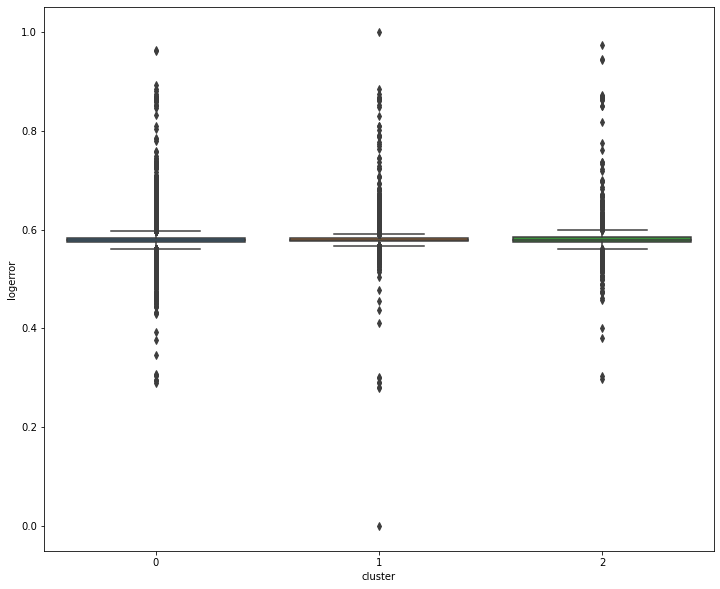

In [94]:
# visualize distribution of logerror by cluster
plt.figure(figsize=(12,10))
sns.boxplot(
    x='cluster',
    y=y_train,
    data=X_train)

### Although the visual does not make it appear that there is much of a difference in logerror for each cluster, I am going to apply a statistical test to confirm this.

In [66]:
# concatenate X_train and y_train so I can check variance of logerror by cluster
X_y = pd.concat([X_train, y_train], axis=1)
X_y.head(2)

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,los_angeles,orange,ventura,age,bath_bed_ratio,cluster,logerror
0,0.11,0.30,0.11,0.63,0.50,0.00,0.02,0.00,0.56,0.09,0.25,0.19,0.11,1.00,0.00,0.00,0.44,0.04,0,0.58
1,0.22,0.30,0.17,0.69,0.95,0.00,0.05,0.00,0.75,0.15,0.15,0.03,0.06,1.00,0.00,0.00,0.25,0.08,1,0.60


**The null hypothesis for the levene test is that there is equal variance in logerror for the clusters**

**The alternate hypothesis for the levene test is that there is unequal variance in logerror for the clusters**

In [84]:
# set alpha
alpha = 0.05

# use levene test to check variance of each cluster
stat, pvalue = stats.levene(
                            X_y[X_y.cluster == 0].logerror,
                            X_y[X_y.cluster == 1].logerror,
                            X_y[X_y.cluster == 2].logerror)

print(f'{stat}, {pvalue}')
if pvalue > alpha:
    print('We fail to reject the null hypothesis')
elif pvalue < alpha:
    print('We reject the null hypothesis')

75.23485872054115, 2.5826532997667535e-33
We reject the null hypothesis


**Because of unequal variance, I will use the Kruskal-Wallis test to compare the mean logerror for each cluster**

**The null hypothesis is that there is no significant difference in the logerror for each of the clusters**

**The alternate hypothesis is that there is a significant difference in the logerror for each of the clusters**

In [86]:
# set alpha
alpha = 0.05

# use kruskal-wallis test to compare means
stats.kruskal(
    X_y[X_y.cluster == 0].logerror,
    X_y[X_y.cluster == 1].logerror,
    X_y[X_y.cluster == 2].logerror)

print(f'{stat}, {pvalue}')
if pvalue > alpha:
    print('We fail to reject the null hypothesis')
elif pvalue < alpha:
    print('We reject the null hypothesis')

75.23485872054115, 2.5826532997667535e-33
We reject the null hypothesis


In [112]:
print(X_y[X_y.cluster == 0].logerror.median())
print(X_y[X_y.cluster == 1].logerror.median())
print(X_y[X_y.cluster == 2].logerror.median())

print(X_y[X_y.cluster == 0].logerror.mean())
print(X_y[X_y.cluster == 1].logerror.mean())
print(X_y[X_y.cluster == 2].logerror.mean())

0.5789855160300726
0.5791290293403021
0.5798789994547153
0.5804286932503051
0.5805207670813737
0.5811339644707141


### Although the visual does not make it seem that 

In [61]:
# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=3)

# find the top 3 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()
f_feature

['bathrooms', 'bedrooms', 'area']

In [113]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

['area', 'lot_area', 'structuretaxvalue']

In [114]:
# select the features to use
X = X_train[['bathrooms', 'bedrooms', 'area']]

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'area'}>, <AxesSubplot:>]],
      dtype=object)

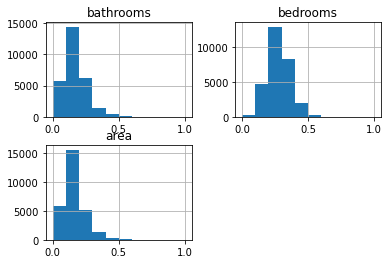

In [115]:
# visualize distribution
X.hist()

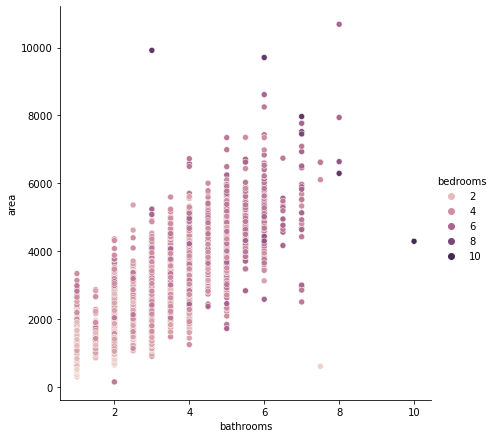

In [129]:
# visualize data to see if there are any obvious clusters
sns.relplot(x = 'bathrooms', y ='area', hue='bedrooms', data = train, height=6)

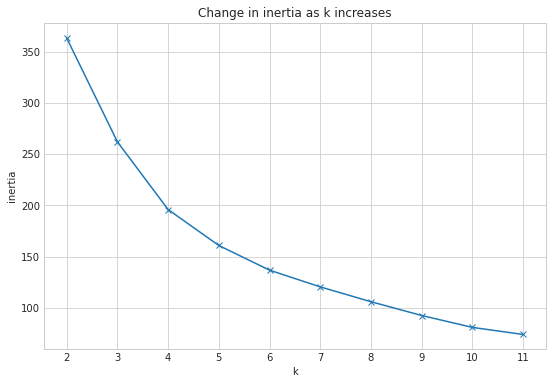

In [120]:
# use elbow method to see what might be a good value for k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

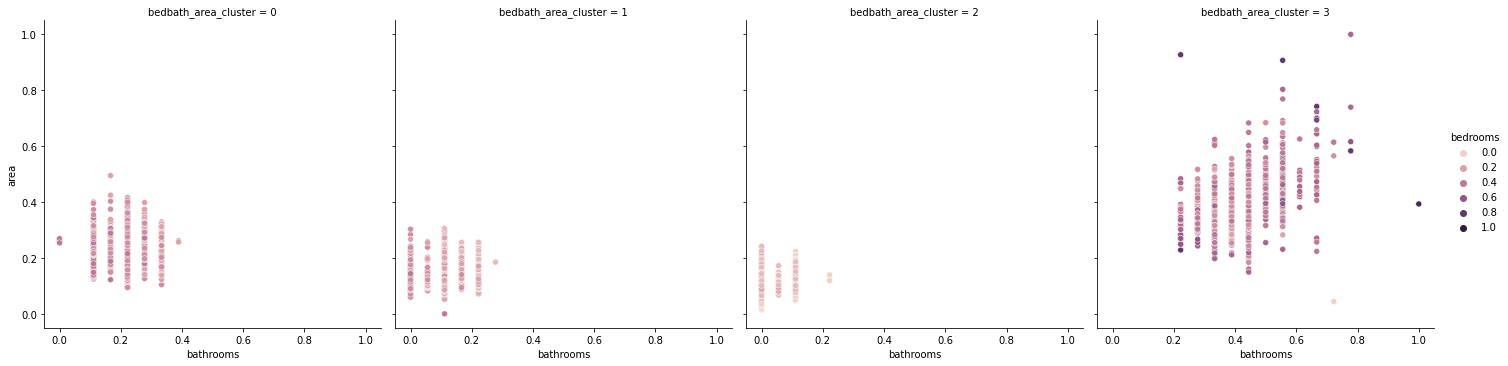

In [133]:
# use KMeans to create 4 clusters

# define the thing
kmeans = KMeans(n_clusters=4, random_state = 369)

# fit the thing
kmeans.fit(X)

# Use the thing to predict
kmeans.predict(X)

# create a new column with the predicted cluster in the original X_train
X_train['bedbath_area_cluster'] = kmeans.predict(X)

# create dataframe of cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

# visualize clustering results
sns.relplot(x = 'bathrooms', y ='area', data = X_train, hue = 'bedrooms', col='bedbath_area_cluster')

<AxesSubplot:xlabel='bedbath_area_cluster', ylabel='logerror'>

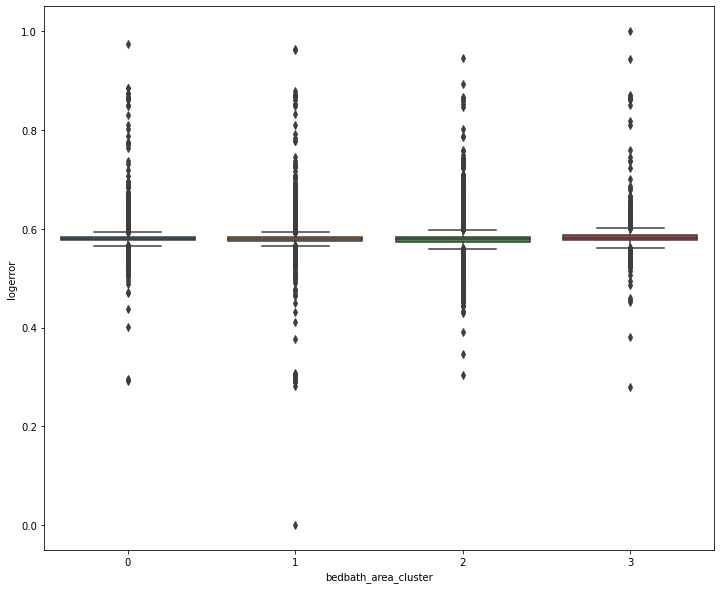

In [141]:
# visualize distribution of logerror by cluster
plt.figure(figsize=(12,10))
sns.boxplot(
    x='bedbath_area_cluster',
    y=y_train,
    data=X_train)